# Heuristic Code

In [141]:
import numpy as np

def char_coeff_FL(X, k):
    if k == 0:
        return 1
    elif k == 1:
        return np.trace(X)
    powers = [X]
    half_k = int(k / 2) 
    for i in range(half_k):
        powers.append(powers[-1] @ X)
    traces = [np.trace(A) for A in powers]
    for i in range(half_k, k):
        traces.append(sum(sum(powers[-1] * powers[i-half_k])))
    x = np.array([[fl_matrix_entry(i, j, traces) for j in range(k)] for i in range(k)])
    return np.linalg.det(x)

def fl_matrix_entry(i, j, l):
    if i > j + 1:
        return 0 
    elif i == j + 1:
        return (len(l) - i - 1)/(i+1)
    else:
        return l[j-i]/(i+1)

def char_coeff_eigen(X, k):
    return esp(np.linalg.eigvalsh(X), k)

def esp(x, k):
    n = len(x)
    if k == 0:
        return 1
    if k == 1:
        return sum(x)
    S = np.zeros((n+1, k))
    for j in range(1, n+1):
        S[j, 0] = S[j-1, 0] + x[j-1]
    for i in range(1, k):
        for j in range(1, n+1):
            S[j, i] = S[j-1, i] + x[j-1] * S[j-1, i-1]
    return S[n, k-1]

def char_poly_built(X, k):
    return np.poly(X)[k]

def char_coeff(X, k):
    #if k < 8:
    #return char_coeff_FL(X, k)
    return char_coeff_eigen(X, k)
    #return char_poly_built(X, k)

def swap(X, i, j):
    if i == j:
        return
    for k in range(len(X)):
        X[k,i], X[k,j]  = X[k,j], X[k,i]
    for k in range(len(X)):
        X[i,k], X[j,k]  = X[j,k], X[i,k]

def conditional_char(X, t, k):
    schur = X[t:, t:] - X[t:, :t] @ np.linalg.inv(X[:t, :t]) @ X[:t, t:]
    return np.linalg.det(X[:t, :t]) * char_coeff(schur, k-t)


def find_subset(A, b, k):
    n = A.shape[1]
    T = []
    npts = 5
    # Use chebyshev nodes
    xs = [np.cos((2*i-1)/(2*npts) * np.pi) for i in range(npts)]
    X0 = np.transpose(A)@A
    V0 = (np.transpose(A) @ np.outer(b, b) @ A)
    Xs = [X0 + x * V0 for x in xs]
    bests = []
    for t in range(k):
        best = -1
        best_heur = 0
        for j in range(t, n):
            chars = []
            for X in Xs:
                swap(X, t, j)
                chars.append(conditional_char(X/1000, t+1, k))
                swap(X, t, j)
            line = np.polyfit(xs, chars, 1)
            heur = line[0]/line[1]
            if heur > best_heur:
                best = j
                best_heur = heur
        for X in Xs:
            swap(X, t, best)
        try:
            while True:
                best = T.index(best)
        except ValueError:
            T.append(best)
        bests.append(best_heur - 1)
    return T, bests

def lin_reg(A, b):
    temp = np.transpose(A) @ b
    return np.dot(b, b) - np.dot(temp, np.linalg.inv(np.transpose(A) @ A) @ temp)

## Orthogonal Matching Pursuit

In [146]:
def omp(A, b, k):
    n = A.shape[1]
    A = A.copy()
    b = b.copy()
    T = []
    bests = []
    for t in range(k):
        best = -1
        best_obj = None
        
        for i in range(n):
            if np.linalg.norm(A[:,i]) < 1e-5:
                continue
            obj = np.dot(b, A[:,i]) / np.linalg.norm(A[:,i])
            if best_obj is None or obj > best_obj:
                best = i
                best_obj = obj 
                
        T.append(best)
        best_vec = A[:, best].copy() / np.linalg.norm(A[:,best])
        for i in range(n):
            A[:,i] -= np.dot(best_vec, A[:,i]) * best_vec
        b -= np.dot(best_vec, b) * best_vec
        bests.append(np.linalg.norm(b)**2)
    return T, bests

# Test Code

In [348]:
import time
def hyp_test(A, b, k_min, k_max):
    hyp_scores = dict()
    hyp_timings = dict()
    for i in range(k_min, k_max):
        start_time = time.time()
        T, bests = find_subset(A,b,i)
        end_time = time.time()
        hyp_timings[i] = end_time - start_time
        hyp_scores[i] = lin_reg(A[:,T], b)        
    return hyp_scores, hyp_timings

def omp_test(A, b, k_min, k_max):
    omp_scores = dict()
    omp_timings = dict()
    for i in range(k_min, k_max):
        start_time = time.time()
        T, bests = omp(A,b,i)
        end_time = time.time()
        omp_timings[i] = end_time - start_time
        omp_scores[i] = lin_reg(A[:,T], b)
    return omp_scores, omp_timings

from sklearn import linear_model
def lasso_test(A, b, threshold, alphas, k_min, k_max):
    # Set the starting scores to be something larger than what we would expect
    lasso_scores = {k : None for k in range(k_min, k_max)}
    lasso_timings = dict()
    for alpha in alphas:
        # Use exponentially decreasing values of alpha to get different sizes of support
        clf = linear_model.Lasso(alpha=alpha, max_iter=10000000)
        start_time = time.time()
        clf.fit(A,b)
        end_time = time.time()
        T = [i for i in range(len(clf.coef_)) if abs(clf.coef_[i]) > threshold]
        k = len(T)
        if k >= k_max or k < k_min:
            continue
        score = lin_reg(A[:,T], b)
        if lasso_scores[k] is None or score < lasso_scores[k]:
            lasso_timings[k] = end_time - start_time
            lasso_scores[k] = score
    return lasso_scores, lasso_timings

import matplotlib.pyplot as plt

def plot_scores(hyp_scores, omp_scores, lasso_scores, k_min, k_max):
    # plot lasso
    if lasso_scores is not None:
        lasso_xs = [k for k in range(k_min, k_max) if lasso_scores[k] is not None]
        lasso_ys = [lasso_scores[k] for k in lasso_xs]
        plt.plot(lasso_xs, lasso_ys, label="Lasso")

    # plot hyp
    if hyp_scores is not None:
        hyp_xs = list(range(k_min, k_max))
        hyp_ys = [hyp_scores[k] for k in hyp_xs]
        plt.plot(hyp_xs, hyp_ys, label="Greedy Cond")

    # plot omp|
    if omp_scores is not None:
        omp_xs = list(range(k_min, k_max))
        omp_ys = [omp_scores[k] for k in omp_xs]
        plt.plot(omp_xs, omp_ys, label="omp")
    
    plt.xticks(list(range(k_min,k_max)))
    plt.xlabel("k")
    plt.ylabel("L2 Error")

    plt.legend()
    plt.show()

# Superconductivity Example

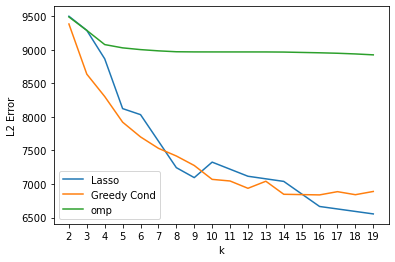

[[2, 9.14022159576416, 0.2147073745727539, 0.061731815338134766], [3, 10.117825031280518, 0.40532708168029785, 0.08967947959899902], [4, 11.446189880371094, 0.32521843910217285, 0.09607195854187012], [5, 11.684353828430176, 0.4748208522796631, 0.17200708389282227], [6, 11.974141120910645, 0.6867637634277344, 0.17789530754089355], [7, 14.391232013702393, 0.5946424007415771, None], [8, 14.0404212474823, 0.7195501327514648, 0.32100963592529297], [9, 13.946961641311646, 0.9735229015350342, 0.3547210693359375], [10, 15.00916337966919, 0.7454178333282471, 0.470383882522583], [11, 16.31105613708496, 0.8535740375518799, None], [12, 18.629433631896973, 1.0357186794281006, 0.7184407711029053], [13, 23.79292368888855, 1.0091559886932373, None], [14, 24.24971842765808, 1.1123857498168945, 0.9578168392181396], [15, 25.97472333908081, 1.1280453205108643, None], [16, 32.018187046051025, 1.3508479595184326, 1.2568137645721436], [17, 28.216292142868042, 1.3294785022735596, None], [18, 39.61784887313843

In [282]:
import pandas as pd
df = pd.read_csv("/usr/people/kevinshu/Downloads/superconduct.csv", delimiter=",")
df = (df - df.mean())/df.std()
A = df.to_numpy()

b = A[:,-1]
A = A[:,:-1]
k_min = 2
k_max = 20
hyp_scores, hyp_timings = hyp_test(A, b, k_min, k_max)
omp_scores, omp_timings = omp_test(A, b, k_min, k_max)
lasso_scores, lasso_timings = lasso_test(A, b, 9e-02, [1.1 ** (t-65) for t in range(100)], k_min, k_max)
plot_scores(hyp_scores, omp_scores, lasso_scores, k_min, k_max)
print([[k,hyp_timings[k],omp_timings[k],lasso_timings[k] if k in lasso_timings else None] for k in range(k_min, k_max)])

# Violent Crime

/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.017572266678002, tolerance: 0.22129999999999975
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.980682587161187, tolerance: 0.22129999999999975
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.940103029089844, tolerance: 0.22129999999999975
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You migh

/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.58045919740839, tolerance: 0.22129999999999975
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.01150602166312, tolerance: 0.22129999999999975
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.386869797664133, tolerance: 0.22129999999999975
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might 

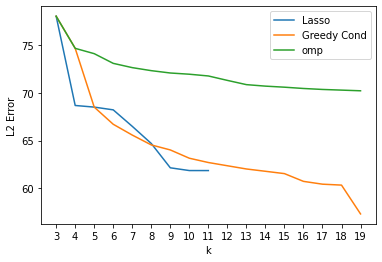

[[3, 4.110548973083496, 0.0410456657409668, 0.04728865623474121], [4, 6.94633412361145, 0.053557634353637695, 0.09480619430541992], [5, 11.667134761810303, 0.06649470329284668, 0.13982582092285156], [6, 10.35294485092163, 0.07919025421142578, 0.2303600311279297], [7, 10.54189682006836, 0.09229493141174316, 0.1537768840789795], [8, 14.092698574066162, 0.10496401786804199, 0.26669836044311523], [9, 15.071165323257446, 0.11787176132202148, 0.4560399055480957], [10, 16.107519149780273, 0.13069558143615723, 0.35843777656555176], [11, 18.485352039337158, 0.14319157600402832, 0.3122384548187256], [12, 20.82084321975708, 0.15565156936645508, None], [13, 23.550981998443604, 0.16817712783813477, None], [14, 25.585909605026245, 0.1744678020477295, None], [15, 28.29284644126892, 0.1811506748199463, None], [16, 31.550673246383667, 0.18719267845153809, None], [17, 33.61722493171692, 0.19437241554260254, None], [18, 37.47920560836792, 0.20035815238952637, None], [19, 39.84412240982056, 0.205904245376

In [340]:
import pandas as pd
df = pd.read_csv("/usr/people/kevinshu/Downloads/CommViolPredUnnormalizedData.txt", delimiter=",")
# Only take interesting columns
df = df.iloc[:,5:-17].replace("?", None).dropna(axis=1)
df = (df - df.mean())/df.std()
A = df.to_numpy()
b = A[:,-1]
A = A[:,:-1]

k_min = 3
k_max = 20
# hyp_scores, hyp_timings = hyp_test(A, b, k_min, k_max)
# omp_scores, omp_timings = omp_test(A, b, k_min, k_max)
lasso_scores, lasso_timings = lasso_test(A, b, 9e-02, [1.1 ** (t-150) for t in range(300)], k_min, k_max)
plot_scores(hyp_scores, omp_scores, lasso_scores, k_min, k_max)
print([[k,hyp_timings[k],omp_timings[k],lasso_timings[k] if k in lasso_timings else None] for k in range(k_min, k_max)])

In [ ]:
delta_scores, delta_timings = lasso_test(A, b, 9e-02, [1.1 ** (-400)], k_min, k_max)
print(delta_scores)

In [342]:
print(delta_scores)

{3: None, 4: None, 5: None, 6: None, 7: None, 8: None, 9: None, 10: None, 11: 61.83619451649065, 12: None, 13: None, 14: None, 15: None, 16: None, 17: None, 18: None, 19: None}


# Sklearn Diabetes Data

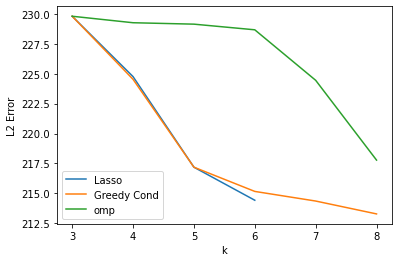

[[3, 0.05415797233581543, 0.002427816390991211, 0.0010402202606201172], [4, 0.055031776428222656, 0.0031044483184814453, 0.0012354850769042969], [5, 0.06625819206237793, 0.003772735595703125, 0.0012674331665039062], [6, 0.0764305591583252, 0.004453897476196289, 0.0031664371490478516], [7, 0.08185386657714844, 0.005078554153442383, None], [8, 0.09123706817626953, 0.005662441253662109, None]]


In [322]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
A = diabetes["data"]
for col in range(len(A[0])):
    A[:, col] -= np.mean(A[:,col])
    A[:, col] /= np.std(A[:,col])
b = diabetes["target"]
b -= np.mean(b)
b /= np.std(b)

k_min = 3
k_max = 9
hyp_scores, hyp_timings = hyp_test(A, b, k_min, k_max)
omp_scores, omp_timings = omp_test(A, b, k_min, k_max)
lasso_scores, lasso_timings = lasso_test(A, b, 9e-02, [1.1 ** (t-65) for t in range(100)], k_min, k_max)
plot_scores(hyp_scores, omp_scores, lasso_scores, k_min, k_max)
print([[k,hyp_timings[k],omp_timings[k],lasso_timings[k] if k in lasso_timings else None] for k in range(k_min, k_max)])

# Wine Dataset

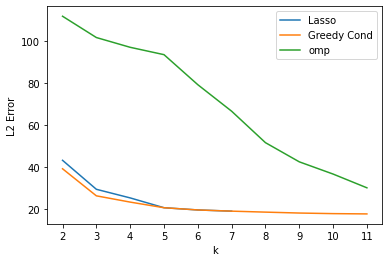

[[2, 0.04844069480895996, 0.001903533935546875, 0.0010123252868652344], [3, 0.10158014297485352, 0.002714395523071289, 0.0018191337585449219], [4, 0.08360171318054199, 0.0035867691040039062, 0.0010781288146972656], [5, 0.10389208793640137, 0.004836320877075195, 0.002889871597290039], [6, 0.12566351890563965, 0.005269527435302734, 0.0011451244354248047], [7, 0.14387178421020508, 0.005921602249145508, 0.0016477108001708984], [8, 0.18005943298339844, 0.006970643997192383, None], [9, 0.31783604621887207, 0.007409811019897461, None], [10, 0.23377227783203125, 0.008306741714477539, None], [11, 0.30708885192871094, 0.008676528930664062, None]]


In [307]:
from sklearn.datasets import load_wine
wine = load_wine()
A = wine["data"].astype(float)
b = wine["target"].astype(float)
for col in range(len(A[0])):
    A[:, col] -= np.mean(A[:,col])
    A[:, col] /= np.std(A[:,col])
b -= np.mean(b)
b /= np.std(b)

k_min = 2
k_max = 12
hyp_scores, hyp_timings = hyp_test(A, b, k_min, k_max)
omp_scores, omp_timings = omp_test(A, b, k_min, k_max)
lasso_scores, lasso_timings = lasso_test(A, b, 9e-02, [1.05 ** (t-400) for t in range(500)], k_min, k_max)
plot_scores(hyp_scores, omp_scores, lasso_scores, k_min, k_max)
print([[k,hyp_timings[k],omp_timings[k],lasso_timings[k] if k in lasso_timings else None] for k in range(k_min, k_max)])

# Regression with random matrices

In [195]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.02)
import random
def test(n,m,k):
    T = random.sample(list(range(n)), k)
    T.sort()
    print("T: ", T)
    A = np.random.normal(loc = 0, scale = 1, size = (m,n))
    b = sum(A[:,i] for i in T)
    S1, scores1 = find_subset(A, b, k)
    print("characteristic: ", S1)
    S1.sort()
    s1 = all(s == t for t, s in zip(T, S1))
    lasso = clf.fit(A, b).coef_
    S2 = [a[1] for a in sorted([(-abs(x),i) for i,x in enumerate(lasso)])[:k]]
    S2.sort()
    s2 = all(s == t for t, s in zip(T, S2))
    S3, scores3 = omp(A,b,k)
    print("omp: ", S3)
    S3.sort()
    s3 = all(s == t for t, s in zip(T, S3))
    norm_b = np.linalg.norm(b)
    print([(norm_b**2 - x1, x3) for x1, x3 in zip(scores1, scores3)])
    return (s1,s2,s3, all(norm_b**2 - x1 >= x3 for x1, x3 in zip(scores1, scores3)))

In [196]:
n = 100
m = 30
iters = 10
count_dict = []
for k in range(6,25):
    counts = [0,0,0]
    for i in range(iters):
        for i, result in enumerate(test(n,m,k)):
            if result:
                counts[i] += 1
    print(counts)
    count_dict.append(counts)
print(count_dict)

T:  [6, 59, 81, 90, 93, 98]
characteristic:  [98, 90, 81, 59, 93, 6]
omp:  [98, 90, 81, 59, 93, 6]
[(78.5567476546986, 96.15139799916021), (42.19170330247985, 51.0749711484665), (26.298345067500534, 30.109910306477303), (16.75938889672969, 17.95774474859308), (10.84151182312371, 11.349514483140174), (6.110667527536862e-12, 5.3260148164570724e-30)]
T:  [22, 28, 29, 35, 69, 84]
characteristic:  [84, 29, 28, 69, 35, 22]
omp:  [84, 29, 28, 69, 35, 22]
[(86.64077023449, 106.87510435196278), (61.19140295013342, 72.43742640020236), (34.97751963082112, 39.906581500965146), (25.25554681030829, 27.445135404494597), (13.982029027319584, 14.703309871171538), (-9.379164112033322e-13, 7.694983879691824e-30)]
T:  [4, 6, 8, 11, 31, 87]
characteristic:  [4, 8, 31, 6, 87, 11]
omp:  [4, 8, 31, 6, 87, 11]
[(84.84673991597026, 105.07578723960935), (61.03025655436997, 72.58713101876899), (46.96144568929046, 53.54635997550257), (32.42299197713035, 35.30114389970806), (16.281167185737388, 17.02912646446662), 

characteristic:  [85, 52, 62, 31, 59, 34, 0, 45]
omp:  [85, 52, 62, 31, 59, 34, 77, 53]
[(68.3843563017091, 89.60040160974084), (58.46961715454255, 74.84641762131567), (47.41196380818835, 57.59020340942249), (36.08831609527488, 41.94479386510055), (27.26294317791954, 30.27585308351808), (21.59419131750559, 23.314039448777756), (17.39811047750473, 18.268816949644588), (14.953435348562152, 14.88675850505076)]
T:  [26, 39, 45, 46, 47, 63, 65, 85]


KeyboardInterrupt: 

In [148]:
n = 10
m = 4
k = 2
import random
for _ in range(1000):
    T = random.sample(list(range(n)), k)
    T.sort()
    A = np.random.normal(loc = 0, scale = 1, size = (m,n))
    b = sum(A[:,i] for i in T)
    S1, scores1 = find_subset(A, b, k)
    S1.sort()
    s1 = all(s == t for t, s in zip(T, S1))
    
    S3, scores3 = omp(A,b,k)
    S3.sort()
    s3 = all(s == t for t, s in zip(T, S3))
    norm_b = np.linalg.norm(b)
    
    norm_b = np.linalg.norm(b)
    print([(norm_b**2 - x1, x3) for x1, x3 in zip(scores1, scores3)])
    
    if s3 and not s1:
        print(A)
        print(b)
        print(T)
        print(find_subset(A, b, k)[0])
        print(omp(A,b,k)[0])
        break

[(1.0377406341161688, 1.7883167077026783), (-1.0658141036401503e-14, 3.158525108795067e-32)]
[(0.24229604056866982, 2.4289620176113815), (0.047786817478977284, 0.13481097900135497)]
[(0.31727381390459364, 0.41440234987234187), (-3.2507330161024584e-13, 7.395570986446985e-32)]
[(1.339812540330998, 2.440332914421233), (0.24086240215732246, 0.4553118440461411)]
[(0.28340747903018304, 0.5015380398748129), (-2.842170943040401e-14, 2.5422275265911513e-32)]
[(0.664353795170614, 1.0460361559754618), (-2.6645352591003757e-15, 4.00593428432545e-32)]
[(0.5922546708244374, 1.0826651607376028), (-5.329070518200751e-15, 2.6500796034768365e-31)]
[(4.2263431721187885, 6.704083527907993), (-7.105427357601002e-15, 9.86076131526265e-32)]
[(0.904208533410241, 1.9984670163133653), (7.105427357601002e-15, 4.005934284325451e-31)]
[(3.0584193313259167, 4.756941524308665), (0.16625928201482232, 0.7726115466844681)]
[(0.9510678296333079, 1.4972922969486562), (0.0, 9.88002061470652e-32)]
[(0.07434752997253824, 0

In [149]:
np.set_printoptions(precision=2)
print(A)
print(T)
print(b)
B = A.copy()
for i in range(B.shape[1]):
    B[:, i] /= np.linalg.norm(B[:, i])
print(B)
print(find_subset(B, b, 2))

[[ 0.03 -0.32  0.3  -0.3  -0.85  2.19  0.48  0.55  0.8   0.38]
 [-1.12 -0.57 -0.04  0.17 -0.84 -2.53 -0.25  0.56 -0.74  0.54]
 [-0.08 -1.47  0.83  0.48  0.26  0.08 -1.63  0.64  0.09  0.2 ]
 [ 0.66 -0.73 -1.47 -0.86 -0.73  0.93  0.9  -0.85 -0.17  0.23]]
[0, 6]
[ 0.5  -1.37 -1.71  1.56]
[[ 0.02 -0.18  0.17 -0.29 -0.6   0.63  0.25  0.42  0.72  0.52]
 [-0.86 -0.32 -0.02  0.16 -0.59 -0.73 -0.13  0.43 -0.67  0.75]
 [-0.06 -0.83  0.49  0.46  0.18  0.02 -0.84  0.48  0.08  0.27]
 [ 0.51 -0.41 -0.86 -0.82 -0.51  0.27  0.46 -0.64 -0.16  0.32]]
([3, 9], [6.656037691903282, 7.272780916696597])


In [165]:
print(omp(B, b, 2))

([6, 0], [0.1906553480939401, 1.0977800683007244e-32])


In [156]:
X = np.transpose(B) @ B
for i in range(10):
    for j in range(i+1, 10):
        print("T ", [i, j])
        A = [[X[i,i], X[i,j]],[X[i,j], X[j,j]]]
        print(np.linalg.det(A))
        A = [[Z[i,i], Z[i,j]],[X[i,j], X[j,j]]]

T  [0, 1]
0.9869531513931562
T  [0, 2]
0.80569147504437
T  [0, 3]
0.6545237267574593
T  [0, 4]
0.9512010688050985
T  [0, 5]
0.4015654674204535
T  [0, 6]
0.8383549957583887
T  [0, 7]
0.4928648660746797
T  [0, 8]
0.742713691867894
T  [0, 9]
0.7635222447573202
T  [1, 2]
0.9938552644502497
T  [1, 3]
0.9980747923025646
T  [1, 4]
0.8734190003087954
T  [1, 5]
0.9999077376044934
T  [1, 6]
0.7424188124532818
T  [1, 7]
0.8792268955989423
T  [1, 8]
0.9938253203486659
T  [1, 9]
0.5223869602772246
T  [2, 3]
0.2321382144817874
T  [2, 4]
0.8070720299961356
T  [2, 5]
0.9914545790702185
T  [2, 6]
0.42049528777323164
T  [2, 7]
0.27972103536305437
T  [2, 8]
0.9021185377899353
T  [2, 9]
0.9956379679656466
T  [3, 4]
0.6545768668909977
T  [3, 5]
0.7430075239820985
T  [3, 6]
0.2580157168516969
T  [3, 7]
0.5095363660206739
T  [3, 8]
0.9780665693878657
T  [3, 9]
0.9719513878337964
T  [4, 5]
0.9934207914404204
T  [4, 6]
0.7850377783855316
T  [4, 7]
0.9939908708925076
T  [4, 8]
0.9965888824078386
T  [4, 9]
0.258

In [179]:
X = np.transpose(B) @ B
b /= np.linalg.norm(b)
D_tot = np.eye(10)
for t in range(10):
    for i in range(10):
        swap(X, 0, i)
        swap(D_tot, 0, i)
        D = np.eye(10)
        D[0,0] = 1/np.sqrt(conditional_char(X, 1, 2))
        X = D @ X @ D
        D_tot = D @ D_tot
Z = X + D_tot @ np.transpose(B) @ np.outer(b, b) @ B @ D_tot
for i in range(10): 
    print(i)
    swap(X, 0, i)
    swap(Z, 0, i)
    print(conditional_char(X, 1, 2))
    print(conditional_char(Z, 1, 2))

0
0.9999999999999996
2.854683636313858
1
0.999994825514956
2.5630020695310787
2
0.9999974496609838
2.8259436624628367
3
0.9999986712071594
2.9907139761711306
4
0.9999989880040638
2.497547943582923
5
0.9999997363333737
2.7805889430265482
6
1.0000018321009967
3.1150202380092353
7
1.000001470413924
2.86550964971077
8
1.0000010863137998
2.513131211551526
9
1.0000006216914992
2.524655654270109


In [73]:
A = np.random.normal(loc = 0, scale = 1, size = (25,400))

In [140]:
B

array([[ 0.48, -0.63,  0.54,  0.57,  0.94, -0.06, -0.44,  0.18,  0.21,
        -0.23],
       [-0.57,  0.65,  0.13,  0.01,  0.05, -0.45,  0.42,  0.02,  0.18,
         0.89],
       [ 0.57,  0.43, -0.58, -0.73,  0.18, -0.87, -0.77,  0.74, -0.89,
         0.13],
       [ 0.36, -0.01,  0.59, -0.38,  0.3 , -0.22,  0.2 ,  0.64,  0.37,
        -0.36]])

In [81]:
# An example of sparse regression.
print(find_subset(A, A[:,1]+A[:,3]-A[:,5], 3))

([3, 1, 5], [52.8597368095047, 80.41534373321, 92.79035322897276])


In [75]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.02)
clf.fit(A, A[:,1]+A[:,3]-A[:,5])
lasso = (clf.coef_)
print(lasso)
[a[1] for a in sorted([(-abs(x),i) for i,x in enumerate(lasso)])[:3]]

[ 0.          0.98631157 -0.          0.98396293 -0.         -0.98040089
  0.         -0.         -0.         -0.         -0.          0.
  0.         -0.          0.          0.          0.          0.
 -0.          0.          0.          0.         -0.          0.
  0.         -0.         -0.         -0.         -0.          0.
  0.          0.          0.          0.         -0.         -0.
  0.         -0.         -0.          0.          0.          0.
  0.         -0.         -0.         -0.          0.          0.
 -0.         -0.         -0.          0.          0.          0.
  0.          0.         -0.          0.         -0.         -0.
  0.         -0.         -0.         -0.         -0.         -0.
  0.          0.          0.         -0.         -0.         -0.
 -0.          0.         -0.          0.         -0.         -0.
 -0.         -0.          0.          0.         -0.          0.
  0.         -0.          0.         -0.          0.         -0.
 -0.         -0. 

[1, 3, 5]

In [78]:
print(omp(A, A[:,1]+A[:,3]-A[:,5], 3))

([3, 1, 22], [43.361546022585614, 12.859484606413732, 9.779391183513335])
